<a href="https://colab.research.google.com/github/OispovIA/masters_thesis/blob/main/notebooks/Training_on_partial_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from numpy.linalg import norm

## Загрузка данных

In [14]:
url = 'https://drive.google.com/uc?id=1-zZFOjNTjPhiwxB3ZyyNjrifOq7JOptU'
data = pd.read_csv(url, sep=';', index_col='Unnamed: 0', encoding='cp1251')

In [15]:
data


,PORO,SW,KRW,system_number,@NTG@,@RVAR@,@PERMX@,l_horiz,param_x,param_y,n_frac,xf_prod,xf_inj,rotation_angle,switch_period,dFrac,КИН (100)
1,0.17,0.3,0.15,1,0.1,50,0.05,0,100,100,1,50,50,45,1,0,0.0441
2,0.17,0.3,0.15,1,0.1,50,0.05,0,100,100,1,50,50,45,3,0,0.0514
3,0.17,0.3,0.15,1,0.1,50,0.05,0,100,100,1,50,50,45,6,0,0.0559
4,0.17,0.3,0.15,1,0.1,50,0.05,0,100,100,1,50,50,0,1,0,0.1548
5,0.17,0.3,0.15,1,0.1,50,0.05,0,100,100,1,50,50,0,3,0,0.1576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124412,0.17,0.3,0.15,1301,0.6,1000,2.00,2000,300,2200,20,100,100,45,10000,100,0.0754
124413,0.17,0.3,0.15,1301,0.6,1000,2.00,1000,300,1200,10,150,150,45,10000,100,0.0769
124414,0.17,0.3,0.15,1301,0.6,1000,2.00,1200,300,1400,12,150,150,45,10000,100,0.0766
124415,0.17,0.3,0.15,1301,0.6,1000,2.00,1500,300,1700,15,150,150,45,10000,100,0.0764


### Перемешиваем данные и удаляем параметры с нулевой дисперсией

In [16]:
data.columns

Index(['PORO', 'SW', 'KRW', 'system_number', '@NTG@', '@RVAR@', '@PERMX@',
       'l_horiz', 'param_x', 'param_y', 'n_frac', 'xf_prod', 'xf_inj',
       'rotation_angle', 'switch_period', 'dFrac', 'КИН (100)'],
      dtype='object')

In [17]:
def subsample(data, frac, seed):  # **kwargs
    return data.sample(frac=frac, random_state=seed).reset_index(drop=True)

In [18]:
data_sample = subsample(data, frac=1, seed=42)

In [19]:
categorical_cols = [
    'system_number',
    'rotation_angle'
]

numerical_cols = [
    '@NTG@',
    '@RVAR@',
    '@PERMX@',
    'l_horiz',
    'param_x',
    'n_frac',
    'xf_prod',
    'xf_inj',
    'switch_period',
    'dFrac'
]


cols_to_drop = [
    'PORO',
    'SW',
    'KRW',
    'param_y'
]

In [ ]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

## Pipeline with linear regression

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(columns=cols_to_drop + ['КИН (100)']),
    data['КИН (100)'],
    test_size=0.2,
    random_state=42
)

preprocessor = ColumnTransformer([
    # Apply MinMaxScaler to numerical data
    ('num', MinMaxScaler(), numerical_cols),
    # Apply OneHotEncoder to categorical data
    ('cat', OneHotEncoder(drop='first'), categorical_cols)
])

lin_reg = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

lin_reg.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['@NTG@', '@RVAR@', '@PERMX@',
                                                   'l_horiz', 'param_x',
                                                   'n_frac', 'xf_prod',
                                                   'xf_inj', 'switch_period',
                                                   'dFrac']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['system_number',
                                                   'rotation_angle'])])),
                ('regressor', LinearRegression())])

In [21]:
lin_reg_pred = lin_reg.predict(X_test)
score = lin_reg.score(X_test, y_test).round(3)

In [40]:
def residual_plot(target, prediction, score=None, marks=10):
    fig, ax = plt.subplots()
    plt.rcParams["figure.figsize"] = (8, 8)

    if score:
        ax.set_title(f'Residual_plot (R2 ={score.round(3)})')

    ax.plot(target, prediction, "o", markevery=marks)
    ax.plot([0, 0.5], [0, 0.5], 'k--', lw=3)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    ax.set_ylim(bottom=0, top=0.5)
    ax.set_xlim(left=0, right=0.5)

    plt.show()

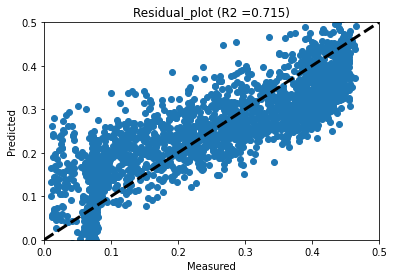

In [23]:
residual_plot(y_test, lin_reg_pred, score)

In [80]:
data[12441:]


,PORO,SW,KRW,system_number,@NTG@,@RVAR@,@PERMX@,l_horiz,param_x,param_y,n_frac,xf_prod,xf_inj,rotation_angle,switch_period,dFrac,КИН (100)
12442,0.17,0.3,0.15,101,0.1,50,2.0,0,300,300,1,100,100,45,10000,0,0.0304
12443,0.17,0.3,0.15,101,0.1,50,2.0,0,300,300,1,100,100,0,10000,0,0.0223
12444,0.17,0.3,0.15,101,0.1,50,2.0,0,300,300,1,100,100,90,10000,0,0.0414
12445,0.17,0.3,0.15,101,0.1,50,2.0,0,300,300,1,150,150,45,10000,0,0.0385
12446,0.17,0.3,0.15,101,0.1,50,2.0,0,300,300,1,150,150,0,10000,0,0.0468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124412,0.17,0.3,0.15,1301,0.6,1000,2.0,2000,300,2200,20,100,100,45,10000,100,0.0754
124413,0.17,0.3,0.15,1301,0.6,1000,2.0,1000,300,1200,10,150,150,45,10000,100,0.0769
124414,0.17,0.3,0.15,1301,0.6,1000,2.0,1200,300,1400,12,150,150,45,10000,100,0.0766
124415,0.17,0.3,0.15,1301,0.6,1000,2.0,1500,300,1700,15,150,150,45,10000,100,0.0764


## Fitting models on subsamples of data

In [88]:
def partial_data_preds(data, pipeline, num_models, seed=42):  # сделать класс

    predicts = []  # self.predicts - или даже задать метод предикт
    scores = []
    for i in np.linspace(0 + 1/num_models, 1, num_models):

        data_sample = subsample(data, frac=i, seed=seed)
        X_train, X_test, y_train, y_test = train_test_split(
            data_sample.drop(columns=cols_to_drop + ['КИН (100)']),
            data_sample['КИН (100)'],
            test_size=0.2,
            random_state=42
        )

        pipeline.fit(X_train, y_train)
        # сохранять в .csv
        predicts.append([np.array(y_test), pipeline.predict(X_test)])
        scores.append([i.round(2), pipeline.score(
            X_test, y_test).round(3)])  # сохранять в .csv
    return predicts, scores


In [90]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor()
preds, score = partial_data_preds(data, forest, 20)

In [121]:
!pip install catboost - q

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 10.7 MB/s eta 0:00:00


In [123]:
from catboost import CatBoostRegressor
cat = CatBoostRegressor(cat_features=categorical_cols)

In [ ]:
preds_cat, score_cat = partial_data_preds(data, cat, 10)

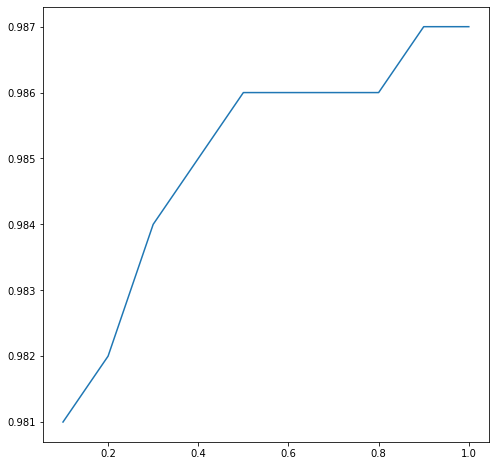

In [125]:
plt.plot(np.array(score_cat)[:, 0], np.array(score_cat)[:, 1])

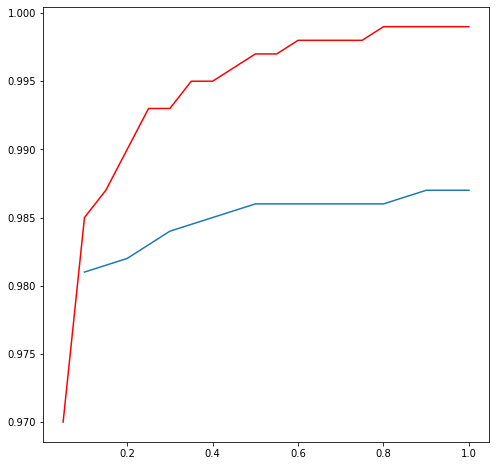

In [128]:
fig, ax = plt.subplots()
ax.plot(np.array(score)[:, 0], np.array(score)[:, 1], 'r')
ax.plot(np.array(score_cat)[:, 0], np.array(score_cat)[:, 1])

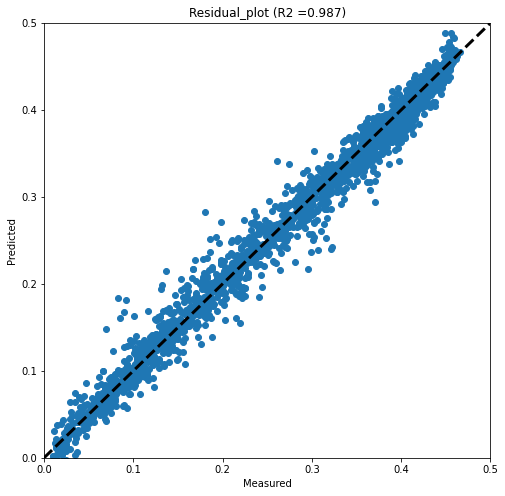

In [127]:
residual_plot(preds_cat[9][0], preds_cat[9][1], score_cat[9][1], 10)
